In [1]:
# from malab import *
from numpy import *
%matplotlib inline
from matplotlib.pyplot import *

from malab.dsfit import fitexp,fitgauss
import json

import numpy as np
import matplotlib.pyplot as plt

No module named 'visa'
Warning VISA library import failed
Warning serial library import failed.
Could not load InstrumentManagerWindow


# (Generate Fake) data + cleaning

## Fake data

Text(0, 0.5, 'Normalized Flux Signal')

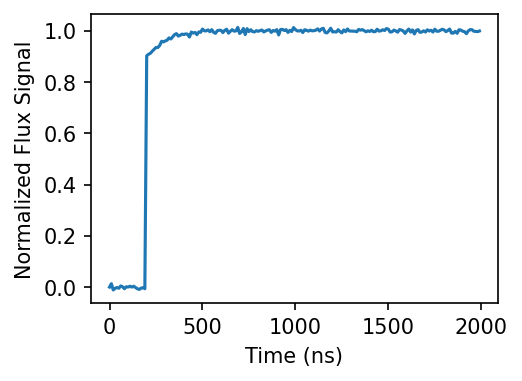

In [2]:
tm_step = 10  ## time sweep step size in measurement

## distortion info ##
jump_time = 200//tm_step  ## time for the jump
dist_amp = -0.1   ## amp for the dis (postive for overshot, neg for undershot)
dist_tau = 100   ## time constant of the decay

## noise info ##
noise_size = 0.005

## gen fake data ##
x_fake = np.arange(0,2000,tm_step)

y_fake = np.zeros(len(x_fake))
y_dist = 1 + dist_amp*e**(-x_fake/dist_tau)
y_fake[jump_time:] = y_dist[:-jump_time]
y_noise = np.random.normal(0, noise_size, len(x_fake))
y_fake = y_fake + y_noise


figure(figsize=(3.5,2.5), dpi = 150)
plot(x_fake, y_fake)
xlabel('Time (ns)')
ylabel('Normalized Flux Signal')

## Find the jump location and get the response on top

Text(0.5, 1.0, 'Find the jump location')

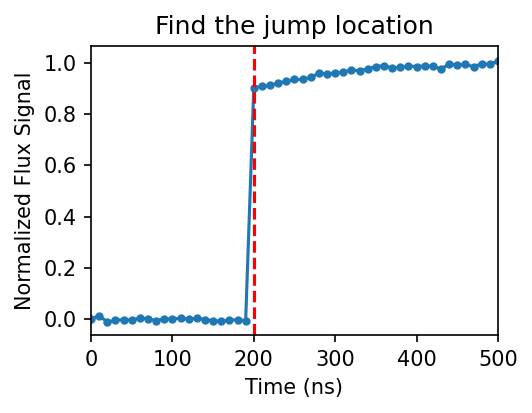

In [3]:
x_full = x_fake
y_full = y_fake

jump_index = 20 ### manually find the jump location

figure(figsize=(3.5,2.5), dpi = 150)
plot(x_full, y_full, '.-')
axvline(x_full[jump_index], ls = '--', color = 'r')
xlabel('Time (ns)')
ylabel('Normalized Flux Signal')
xlim(0,500)
title('Find the jump location')

Text(0.5, 1.0, 'Cleaned disotortion data')

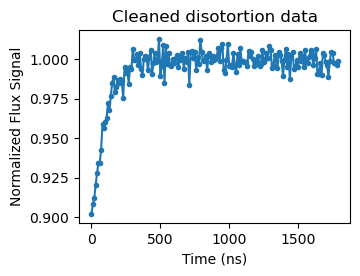

In [4]:
x_cleaned = x_fake[jump_index:] - x_fake[jump_index]
y_cleaned = y_full[jump_index:]

figure(figsize=(3.5,2.5), dpi = 100)
plot(x_cleaned, y_cleaned, '.-')
xlabel('Time (ns)')
ylabel('Normalized Flux Signal')
title('Cleaned disotortion data')

# Fit the resonse

In [5]:
import numpy as np
import math as math
import matplotlib.pyplot as plt
import scipy
import scipy.fftpack
import cmath
import numpy

from scipy import optimize


def fitgeneral(xdata, ydata, fitfunc, fitparams, domain=None, showfit=False, showstartfit=False, showdata=True,
               label="", mark_data='bo', mark_fit='r-'):
    """Uses optimize.leastsq to fit xdata ,ydata using fitfunc and adjusting fit params"""

    # sort data
    order = np.argsort(xdata)
    xdata = xdata[order]
    ydata = ydata[order]

    if domain is not None:
        fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
    else:
        fitdatax=xdata
        fitdatay=ydata
#    print 'minimum', np.min(fitdatay)
#    ymin=np.min(fitdatay)
    errfunc = lambda p, x, y: (fitfunc(p,x) - y) #there shouldn't be **2 # Distance to the target function
    startparams=fitparams # Initial guess for the parameters
    bestfitparams, success = optimize.leastsq(errfunc, startparams[:], args=(fitdatax,fitdatay))
    if showfit:
        if showdata:
            plt.plot(fitdatax,fitdatay,mark_data,label=label+" data")
        if showstartfit:
            plt.plot(fitdatax,fitfunc(startparams,fitdatax),label=label+" startfit")
        plt.plot(fitdatax,fitfunc(bestfitparams,fitdatax),mark_fit,label=label+" fit")
        if label!='': plt.legend()
        err=math.fsum(errfunc(bestfitparams,fitdatax,fitdatay))
#         print('the best fit has an RMS of {0}'.format(err))
#    plt.t
#    plt.figtext()    
    return bestfitparams


## Fit the response

In [6]:
_option = 0 ## 0 for single exp + linear slope; 1 for double exp + linear slope

if _option == 0:
    def disfunc(p,x):
        """p[0]+p[1]*exp(-(x-p[2])/p[3])+p[4]*x"""
        return p[0]+p[1]*math.e**(-(x-p[2])/p[3])+p[4]*x

    def fitdistor(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
        """p[0]+p[1]*exp(-(x-p[2])/p[3])+p[4]*x"""
        if domain is not None:
            fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
        else:
            fitdatax=xdata
            fitdatay=ydata
        if fitparams is None:    
            fitparams=[0.,0.,0.,0.,0.]
            fitparams[4] = (mean(fitdatay[-50:-40])- mean(fitdatay[-11:-1]))/(mean(fitdatax[-50:-40])- mean(fitdatax[-11:-1]))
            fitparams[2]=fitdatax[0]
            fitparams[0]=mean(fitdatay[-11:-1]) - fitparams[4]*(fitdatax[-1]-mean(fitdatax[-11:-1]))

            fitparams[1]=fitdatay[0]-fitdatay[-1]
            fitparams[3]=(fitdatax[-1]-fitdatax[0])/3.

        #print fitparams
        p1 = fitgeneral(fitdatax, fitdatay, disfunc, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                        label=label)
        return p1 
else:
    def disfunc(p,x):
        """p[0]+p[1]*exp(-(x-p[2])/p[3]) + p[4]*exp(-(x-p[2])/p[5])+p[6]*x"""
        return p[0]+p[1]*math.e**(-(x-p[2])/p[3]) + p[4]*math.e**(-(x-p[2])/p[5]) +p[6]*x

    def fitdistor(xdata,ydata,fitparams=None,domain=None,showfit=False,showstartfit=False,label=""):
        """p[0]+p[1]*exp(-(x-p[2])/p[3]) + p[4]*exp(-(x-p[2])/p[5])+p[6]*x"""
        if domain is not None:
            fitdatax,fitdatay = selectdomain(xdata,ydata,domain)
        else:
            fitdatax=xdata
            fitdatay=ydata
        if fitparams is None:    
            fitparams=[0.,0.,0.,0.,0.,0.,0.]
            fitparams[6] = (mean(fitdatay[-50:-40])- mean(fitdatay[-11:-1]))/(mean(fitdatax[-50:-40])- mean(fitdatax[-11:-1]))
            fitparams[2]=fitdatax[0]
            fitparams[0]=mean(fitdatay[-11:-1]) - fitparams[6]*(fitdatax[-1]-mean(fitdatax[-11:-1]))

            fitparams[1]=fitdatay[0]-fitdatay[-1]/2
            fitparams[3]=(fitdatax[-1]-fitdatax[0])/3.

            fitparams[4]=fitdatay[0]-fitdatay[-1]/2
            fitparams[5]=(fitdatax[-1]-fitdatax[0])/3.

        #print fitparams
        p1 = fitgeneral(fitdatax, fitdatay, disfunc, fitparams, domain=None, showfit=showfit, showstartfit=showstartfit,
                        label=label)
        return p1 

Text(0.5, 1.0, 'Fit the response')

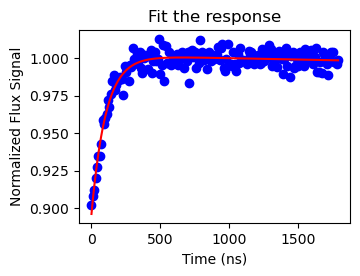

In [7]:
y_for_fit = y_cleaned
x_for_fit = x_cleaned

figure(figsize=(3.5,2.5), dpi = 100)
fit_para = fitdistor(x_for_fit,y_for_fit,showfit=True)

xlabel('Time (ns)')
ylabel('Normalized Flux Signal')
title('Fit the response')

## Resample the fit function based on hardward waveform time resolution

Text(0.5, 1.0, 'Resample response')

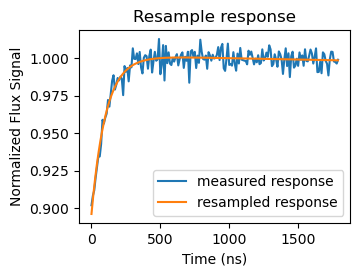

In [8]:
awg_delta_t = 1  ## ns, awg waveform time resolution, by default we use 1ns (this is for QM OPX+)
x_resample = np.arange(x_for_fit[0], x_for_fit[-1],awg_delta_t)
y_resample = disfunc(fit_para, x_resample)


figure(figsize=(3.5,2.5), dpi = 100)
plot(x_cleaned, y_cleaned, label = 'measured response')
plot(x_resample, y_resample, label = 'resampled response')
legend()
xlabel('Time (ns)')
ylabel('Normalized Flux Signal')
title('Resample response')

## Build the kernel $H(t)$ in time domain

Text(0.5, 1.0, 'H(t)')

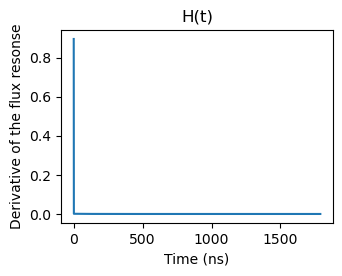

In [9]:
H_time = np.array(list([y_resample[0]]) + list(np.diff(y_resample)))

figure(figsize=(3.5,2.5), dpi = 100)
plot(x_resample, H_time)
xlabel('Time (ns)')
ylabel('Derivative of the flux resonse')
title('H(t)')

# Compensation with precalculation

## Find the kernel $H(\omega)$ frequency domain

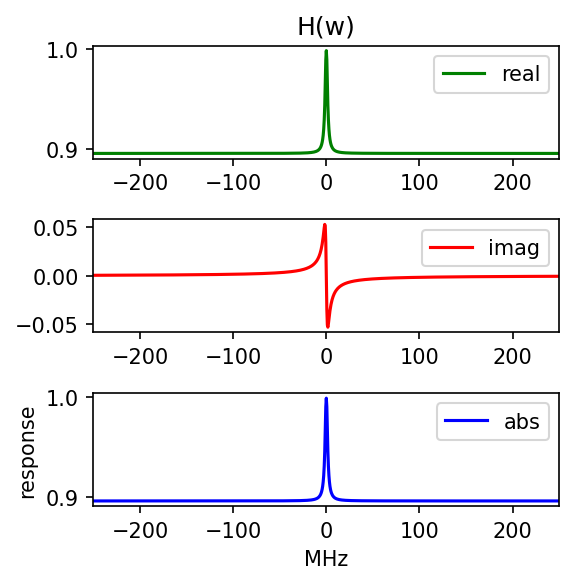

In [10]:

H_omega = np.fft.fft(H_time)
fs = np.fft.fftfreq(H_time.size, d= awg_delta_t*1e-9) ## ns -> s ; for normal frequency
sortidx = argsort(fs)

frange = [-250,250] ## plot range in Hz

figure(figsize = (4,4),dpi = 150)

subplot(311,title='H(w)')
plot(fs[sortidx]/1e6, real(H_omega[sortidx]), 'g', label='real')
xlim(frange)
legend(loc='upper right')

subplot(312)
plot(fs[sortidx]/1e6, imag(H_omega[sortidx]), 'r', label='imag')
xlim(frange)
legend(loc='upper right')

subplot(313, xlabel='MHz', ylabel='response')
plot(fs[sortidx]/1e6, abs(H_omega[sortidx]), 'b', label='abs')
xlim(frange)
legend(loc='upper right')    

tight_layout()

## Calculate the pre compensation kernel in time domain - kernel

In [11]:
H_omega_inv = 1/ H_omega
kernel = np.fft.fftshift(np.fft.ifft(H_omega_inv))

reduce_kernel_size = True
if reduce_kernel_size:
    kernel_len = 1000
    dd = 1 ## to make sure there is no shift between the target waveform and the pre-compensated waveform
    tkernel = x_resample[int(kernel.size/2-kernel_len/2):int(kernel.size/2+kernel_len/2)]-(kernel.size/2.0)*awg_delta_t
    kernel = kernel[int(kernel.size/2-kernel_len/2+dd):int(kernel.size/2+kernel_len/2+dd)]

    print('New kernel size')
    print(kernel.size)
    print(tkernel[0],tkernel[-1])
    print(kernel[0],kernel[-1])

New kernel size
1000
-500.0 499.0
(1.8313039924877432e-06+1.9318703944502455e-18j) (-4.098152137710711e-06+2.7304742329452812e-17j)


c:\Users\G41Lab\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(1090.0, 1110.0)

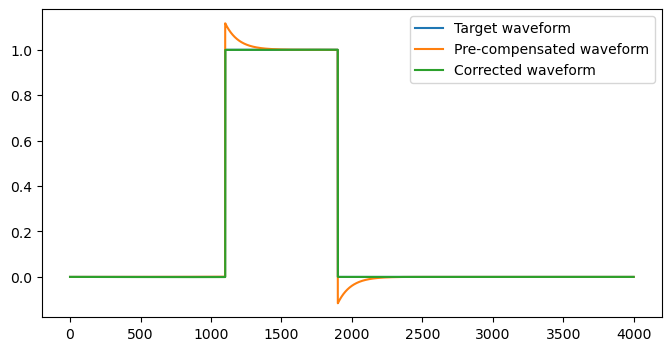

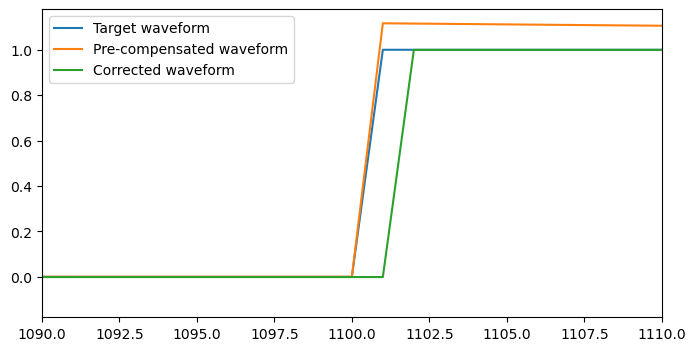

In [12]:
step_t = np.arange(0,4000,awg_delta_t)
step_data = ((abs(step_t-1500))<400) #*(step_t<2)

H_time_org = np.fft.fftshift(H_time)
H_time_inv = kernel

wf1 = np.convolve(step_data, H_time_inv, 'same')
wf2 = np.convolve(wf1, H_time_org, 'same')

figure(figsize=(8,4), dpi = 100)
plot(step_t, step_data, label = 'Target waveform')
plot(step_t, wf1, label = 'Pre-compensated waveform')
plot(step_t, wf2, label = 'Corrected waveform')
legend()

figure(figsize=(8,4), dpi = 100)
plot(step_t, step_data, label = 'Target waveform')
plot(step_t, wf1, label = 'Pre-compensated waveform')
plot(step_t, wf2, label = 'Corrected waveform')
legend()
xlim(1100-10,1100+10)